In [1]:
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib import gridspec
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, balanced_accuracy_score, auc, roc_auc_score, log_loss, mean_squared_error
from sklearn.datasets import load_breast_cancer, load_diabetes, load_wine

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from rit.tree import DecisionTreeClassifier as MyDecisionTreeClassifier
from rit.tree import DecisionTreeRegressor as MyDecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from rit.ensemble import RandomForestClassifier as MyRandomForestClassifier
from rit.ensemble import RandomForestRegressor as MyRandomForestRegressor

from mlxtend.plotting import plot_decision_regions
from sklearn.datasets import make_classification, make_regression

from scipy.stats import f_oneway

from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

from scipy.stats import mannwhitneyu

## helpfunctions

In [36]:
def draw_tree(tree, feature_names):
    n_nodes = tree.tree_.node_count
    children_left = tree.tree_.children_left
    children_right = tree.tree_.children_right
    feature = tree.tree_.feature
    threshold = tree.tree_.threshold
    values = tree.tree_.value

    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, 0)]
    while len(stack) > 0:
        node_id, depth = stack.pop()
        node_depth[node_id] = depth
        is_split_node = children_left[node_id] != children_right[node_id]
        if is_split_node:
            stack.append((children_left[node_id], depth + 1))
            stack.append((children_right[node_id], depth + 1))
        else:
            is_leaves[node_id] = True

    print(
        "The binary tree structure has {n} nodes and has "
        "the following tree structure:\n".format(n=n_nodes)
    )
    for i in range(n_nodes):
        if is_leaves[i]:
            print(
                "{space}node={node} is a leaf node with value={value}.".format(
                    space=node_depth[i] * "\t", node=i, value=np.around(values[i], 3)
                )
            )
        else:
            print(
                "{space}node={node} is a split node with value={value}: "
                "go to node {left} if {feature} <= {threshold} "
                "else to node {right}.".format(
                    space=node_depth[i] * "\t",
                    node=i,
                    left=children_left[i],
                    feature=feature_names[feature[i]],
                    threshold=threshold[i],
                    right=children_right[i],
                    value=np.around(values[i], 3),
                )
            )

In [24]:
def dependency_matrix_tree_ver_1(tree, n_features):
    matrix = np.zeros((n_features,  n_features))

    n_nodes = tree.tree_.node_count
    children_left = tree.tree_.children_left
    children_right = tree.tree_.children_right
    feature = tree.tree_.feature
    threshold = tree.tree_.threshold
    values = tree.tree_.value

    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)

    stack = [(0, 0)]
    while len(stack) > 0:
        node_id, depth = stack.pop()
        node_depth[node_id] = depth
        is_split_node = children_left[node_id] != children_right[node_id]
        if is_split_node:
            stack.append((children_left[node_id], depth + 1))
            stack.append((children_right[node_id], depth + 1))
            matrix[feature[node_id]][feature[children_left[node_id]]] += 1
            matrix[feature[node_id]][feature[children_right[node_id]]] += 1
        else:
            is_leaves[node_id] = True
    return matrix / (n_nodes - 1)

In [25]:
def dependency_matrix_forest(model, n_features, alpha):
  matrix = np.zeros((n_features,  n_features))

  for tree in model.estimators_:
    matrix += dependency_matrix_tree_ver_1(tree, n_features)

  N = model.n_estimators
  matrix = matrix / N

  return matrix

In [2]:
def Visualise_classification_2D(X, y):
  cols = ['blue', 'red', 'green', 'yellow']
  plt.figure(figsize=(9,4))
  plt.xlim((np.min(X) - 0.5, np.max(X) + 0.5)),
  plt.ylim((np.min(X) - 0.5, np.max(X) + 0.5))

  for k in np.unique(y):
      plt.plot(X[y==k,0], X[y==k,1], 'o',
                label='класс {}'.format(k), color=cols[k])

  plt.legend(loc='best')
  plt.xlabel('x1')
  plt.ylabel('x2')
  plt.show()

def Visualise_regression_2D(X, y, xlim, ylim):
  plt.figure(figsize=[9, 4])
  plt.xlim((xlim[0], xlim[1]))
  plt.ylim((ylim[0], ylim[1]))

  sc = plt.scatter(X[:, 0], X[:, 1], c=y, s=5)

  plt.colorbar(sc)

  plt.xlabel('x1')
  plt.ylabel('x2')
  plt.show()

In [11]:
def func_reg(X, y, alpha):
  rf = MyRandomForestRegressor(random_state=0,
                               max_leaf_nodes=2**5,
                               bootstrap=True,
                               oob_score=mean_squared_error,
                               n_jobs=1,
                               rit_alpha=alpha,
                               subforest_importance=True,
                               normalize_importance=False,
                               importance_avrg='median')
  rf.fit(X, y)
  return rf.oob_score_

def func_class(X, y, alpha):
  rf = MyRandomForestClassifier(random_state=0,
                               max_leaf_nodes=2**5,
                               bootstrap=True,
                               oob_score=accuracy_score,
                               n_jobs=1,
                               rit_alpha=alpha,
                               subforest_importance=True,
                               normalize_importance=False,
                               importance_avrg='median')
  rf.fit(X, y)
  return rf.oob_score_

# Начало

Будем исследовать 3 выборки для решрессии и 2 выборки для классификации. Для регрессии будем использовать выборки $y = x_1 + x_2$(нет взаимодействия), $y = x_1 \cdot x_2$(есть взаимодействие), где $x_1$, $x_2$ - независимые, и $y = x_1 + x_2$, где $x_1$, $x_2$ - линейно зависимы.
Для регрессии будем использовать выборку, где $x_1$, $x_2$ взаимодействуют и где не взаимодействуют.

# Выборки

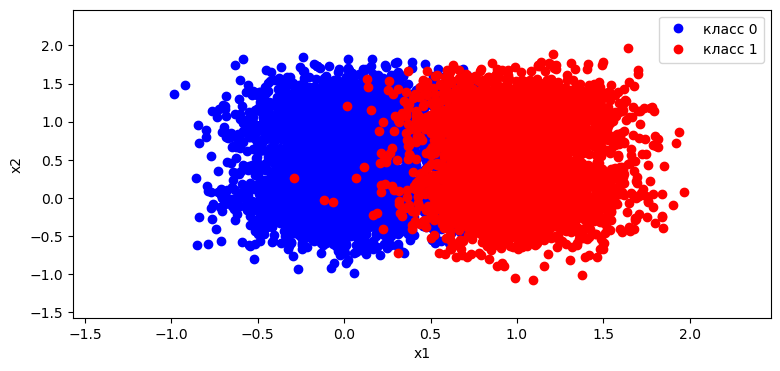

In [ ]:
def data_classification_2D_1():
  n = 2
  l = 2000
  X1 = np.array([[0,0]]) + 0.3*np.random.randn(l, n)
  X2 = np.array([[0,1]]) + 0.3*np.random.randn(l, n)
  X3 = np.array([[1,0]]) + 0.3*np.random.randn(l, n)
  X4 = np.array([[1,1]]) + 0.3*np.random.randn(l, n)

  X = np.vstack([X1, X2, X3, X4])
  y = np.hstack([[0]*l, [0]*l, [1]*l, [1]*l])

  return X, y

X, y = data_classification_2D_1()
Visualise_classification_2D(X, y)

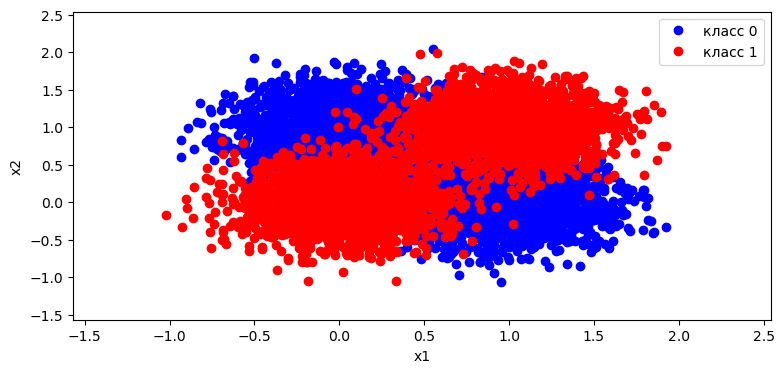

In [10]:
def data_classification_2D_2():
  n = 2
  l = 2000
  X1 = np.array([[0,0]]) + 0.3*np.random.randn(l, n)
  X2 = np.array([[0,1]]) + 0.3*np.random.randn(l, n)
  X3 = np.array([[1,0]]) + 0.3*np.random.randn(l, n)
  X4 = np.array([[1,1]]) + 0.3*np.random.randn(l, n)

  X = np.vstack([X1, X2, X3, X4])
  y = np.hstack([[1]*l, [0]*l, [0]*l, [1]*l])

  return X, y

X, y = data_classification_2D_2()
Visualise_classification_2D(X, y)

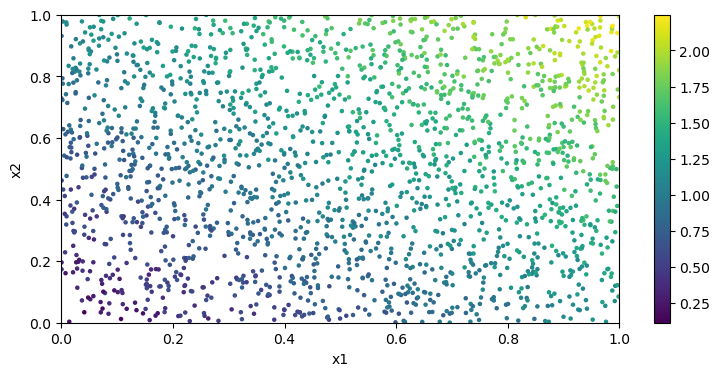

In [ ]:
def data_regression_2D_1():
  n = 2
  N = 2000

  X1 = np.random.random(N)
  X2 = np.random.random(N)

  y = X1 + X2 + np.random.random(N)/3
  X = np.vstack([X1, X2]).transpose(1, 0)

  return X, y

X, y = data_regression_2D_1()
Visualise_regression_2D(X, y, (0, 1), (0, 1))

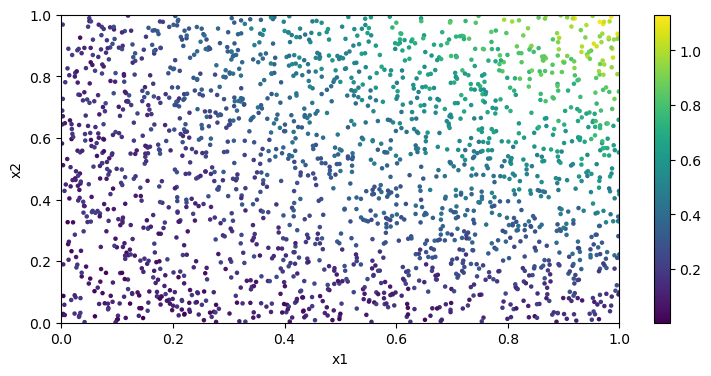

In [5]:
def data_regression_2D_2():
  n = 2
  N = 2000

  X1 = np.random.random(N)
  X2 = np.random.random(N)

  y = X1 * X2 + np.random.random(N)/5
  X = np.vstack([X1, X2]).transpose(1, 0)

  return X, y

X, y = data_regression_2D_2()
Visualise_regression_2D(X, y, (0, 1), (0, 1))

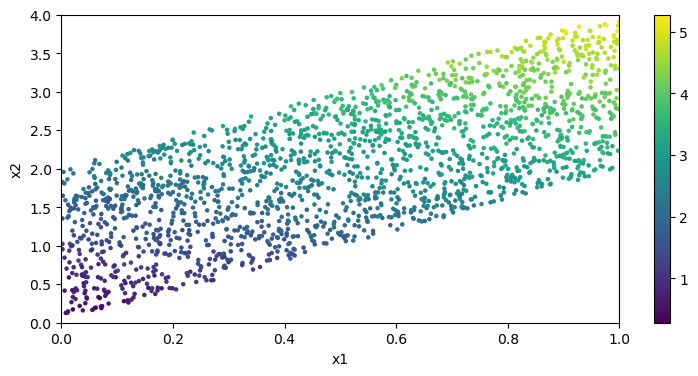

In [20]:
def data_regression_2D_3():
  n = 2
  N = 2000

  X1 = np.random.random(N)
  X2 = 2 * X1 + np.random.random(N) * 2

  y = X1 + X2 + np.random.random(N)/2
  X = np.vstack([X1, X2]).transpose(1, 0)

  return X, y

X, y = data_regression_2D_3()
Visualise_regression_2D(X, y, (0, 1), (0, 4))

# Оценка выборок

Проведем некоторые оценки выборок, прежде всего нужно узнать, как меняется score модели, при увеличении alpha, предполагается, что для модели с признаками, которые не взаимодействуют ($y = x_1 + x_2$), можно увеливать alpha до 1 и качество модели не пострадает, а для модели, где признаки взаимодействуют, так уже сделать не получится и модель будет сильно терять в качестве при приближении alpha к 1.

## Regression

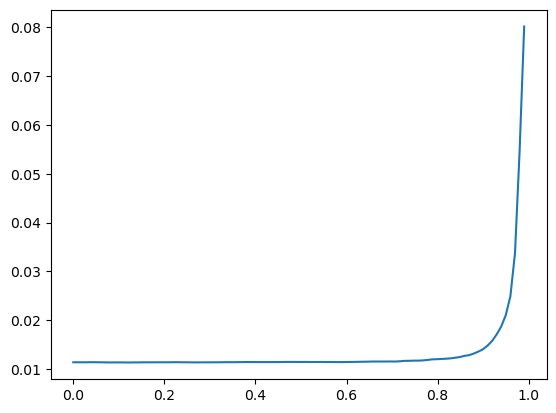

In [14]:
# 1
X, y = data_regression_2D_1()
alphas = np.linspace(0, 1, 100)
arr_4 = []
for alpha in alphas[:-1]:
    arr_4.append(func_reg(X, y, alpha))
plt.plot(alphas[:-1], arr_4)
plt.show()

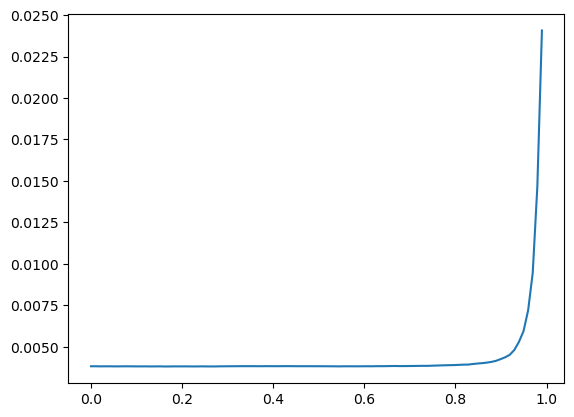

In [15]:
# 2
X, y = data_regression_2D_2()
alphas = np.linspace(0, 1, 100)
arr_4 = []
for alpha in alphas[:-1]:
    arr_4.append(func_reg(X, y, alpha))
plt.plot(alphas[:-1], arr_4)
plt.show()

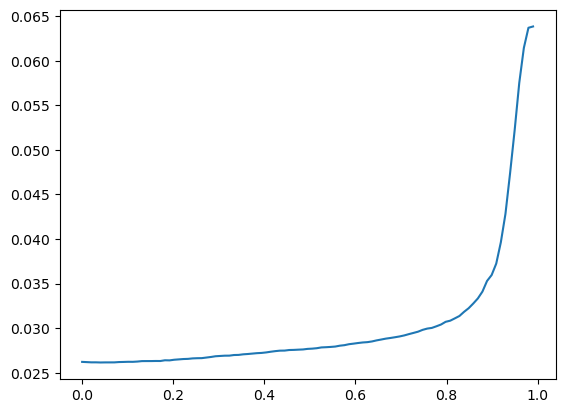

In [21]:
# 3
X, y = data_regression_2D_3()
alphas = np.linspace(0, 1, 100)
arr_4 = []
for alpha in alphas[:-1]:
    arr_4.append(func_reg(X, y, alpha))
plt.plot(alphas[:-1], arr_4)
plt.show()

## Classification

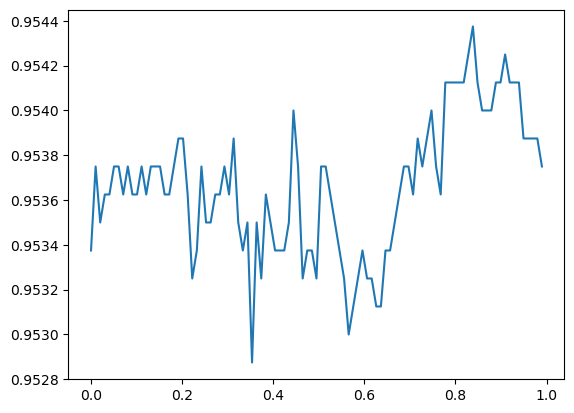

In [18]:
# 1
X, y = data_classification_2D_1()
alphas = np.linspace(0, 1, 100)
arr_4 = []
for alpha in alphas[:-1]:
    arr_4.append(func_class(X, y, alpha))
plt.plot(alphas[:-1], arr_4)
plt.show()

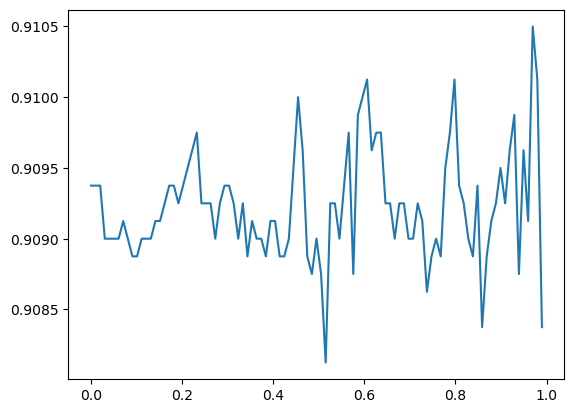

In [17]:
# 2
X, y = data_classification_2D_2()
alphas = np.linspace(0, 1, 100)
arr_4 = []
for alpha in alphas[:-1]:
    arr_4.append(func_class(X, y, alpha))
plt.plot(alphas[:-1], arr_4)
plt.show()

# Выводы:

У регрессии для обоих случаев видим одинаковую тенденцию, что score увеличивается при приближении alpha к 1, но если признаки зависимы, то при увеличении alpha score намного быстрее увеличивается. Для классификации видим, что увеличение alpha примерно одинаково влияло на score. 

Таким образом, скорее всего, изначальное предположение о связи взаимодействия признаков таким образом неверно и ключ лежит в том, как устроены деревья RF при различных alpha. Понятно, что если признак смог пройти через большой alpha и появиться в дереве после другого признака, то, возможно, у них есть какое-то взаимодействие. Построив таблицу количества появления признак один после другого в каждом дереве и усреднив по лесу, можно построить графики для некоторых комбинаций элементов полученной матрицы в зависимости от alpha. Так, взаимодействие должно проявляться в количестве случаев, когда один признак идет после другого, построим график для зависимости ($M[0][1] + M[1][0]$) от alpha, где M - матрица, где в $M_{ij}$ - часть случаев, когда признак j шел после признака i. 

# Доп. графики

In [37]:
def func_matr_1(X, y, alpha):
  rf = MyRandomForestRegressor(random_state=1,
                               max_leaf_nodes=2**5,
                               bootstrap=True,
                               oob_score=mean_squared_error,
                               n_jobs=1,
                               rit_alpha=alpha,
                               subforest_importance=True,
                               normalize_importance=False,
                               importance_avrg='median')
  rf.fit(X, y)
  matr = dependency_matrix_forest(rf, len(X[0]), alpha)
  return  (matr[0][1] + matr[1][0])
def func_matr_2(X, y, alpha):
  rf = MyRandomForestClassifier(random_state=1,
                               max_leaf_nodes=2**5,
                               bootstrap=True,
                               oob_score=accuracy_score,
                               n_jobs=1,
                               rit_alpha=alpha,
                               subforest_importance=True,
                               normalize_importance=False,
                               importance_avrg='median')
  rf.fit(X, y)
  matr = dependency_matrix_forest(rf, len(X[0]), alpha)
  return  (matr[0][1] + matr[1][0])

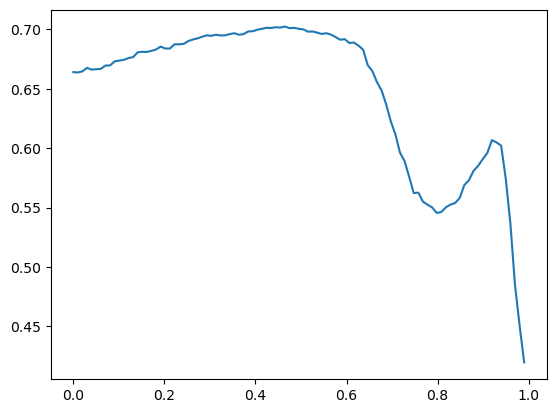

In [32]:
X, y = data_regression_2D_1()
alphas = np.linspace(0, 1, 100)
arr_4 = []
for alpha in alphas[:-1]:
    arr_4.append(func_matr_1(X, y, alpha))
plt.plot(alphas[:-1], arr_4)
plt.show()

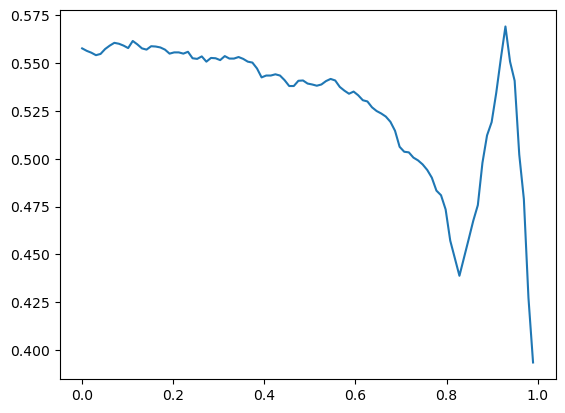

In [33]:
X, y = data_regression_2D_2()
alphas = np.linspace(0, 1, 100)
arr_4 = []
for alpha in alphas[:-1]:
    arr_4.append(func_matr_1(X, y, alpha))
plt.plot(alphas[:-1], arr_4)
plt.show()

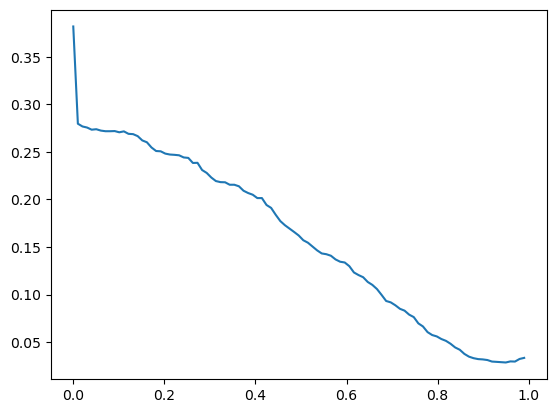

In [38]:
X, y = data_classification_2D_1()
alphas = np.linspace(0, 1, 100)
arr_4 = []
for alpha in alphas[:-1]:
    arr_4.append(func_matr_2(X, y, alpha))
plt.plot(alphas[:-1], arr_4)
plt.show()

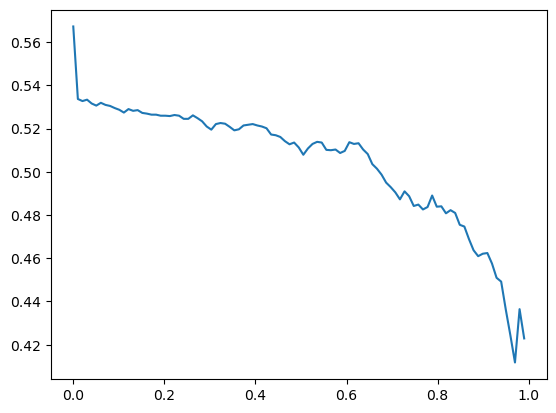

In [39]:
X, y = data_classification_2D_2()
alphas = np.linspace(0, 1, 100)
arr_4 = []
for alpha in alphas[:-1]:
    arr_4.append(func_matr_2(X, y, alpha))
plt.plot(alphas[:-1], arr_4)
plt.show()

# Выводы

Из этих графиков сложно что-то сказать про регрессию, но можно сделать выводы для классификации: можно наблюдать, что общее количество пар признаков, где разные признаки идут друг за другом, уменьшается с ростом alpha (как и ожидалось), но видно, что для выборки, где признаки не взаимодействуют, при alpha = 1 (или близко к 1), их доля почти 0, а для взаимодействующих эта доля составляет $\approx 30\%$, что говорит нам о виде деревьев в этих обученных моделях: в первой, при alpha = 1 деревья будут состоять из 1 признака, а во 2ой модели деревья будут содержать оба признака:

In [41]:
# 1
X, y = data_classification_2D_1()
rf = MyRandomForestClassifier(random_state=1,
                               max_leaf_nodes=2**5,
                               bootstrap=True,
                               oob_score=accuracy_score,
                               n_jobs=1,
                               rit_alpha=0.99999,
                               subforest_importance=True,
                               normalize_importance=False,
                               importance_avrg='median')
rf.fit(X, y)
draw_tree(rf.estimators_[0], ["x1", "x2"])

The binary tree structure has 63 nodes and has the following tree structure:

node=0 is a split node with value=[[3921. 4079.]]: go to node 1 if x2 <= 1.6781445145606995 else to node 2.
	node=1 is a split node with value=[[3908. 4052.]]: go to node 3 if x2 <= 1.6338823437690735 else to node 4.
	node=2 is a split node with value=[[13. 27.]]: go to node 5 if x2 <= 1.7592087984085083 else to node 6.
		node=3 is a split node with value=[[3889. 4045.]]: go to node 10 if x2 <= 1.596944510936737 else to node 9.
		node=4 is a leaf node with value=[[19.  7.]].
		node=5 is a leaf node with value=[[ 2. 16.]].
		node=6 is a split node with value=[[11. 11.]]: go to node 7 if x2 <= 1.7867273688316345 else to node 8.
			node=7 is a leaf node with value=[[4. 0.]].
			node=8 is a leaf node with value=[[ 7. 11.]].
			node=9 is a split node with value=[[ 4. 13.]]: go to node 16 if x2 <= 1.6151000261306763 else to node 15.
			node=10 is a split node with value=[[3885. 4032.]]: go to node 12 if x2 <= 1.584

Только признак 2

In [43]:
# 2
X, y = data_classification_2D_2()
rf = MyRandomForestClassifier(random_state=1,
                               max_leaf_nodes=2**5,
                               bootstrap=True,
                               oob_score=accuracy_score,
                               n_jobs=1,
                               rit_alpha=0.99,
                               subforest_importance=True,
                               normalize_importance=False,
                               importance_avrg='median')
rf.fit(X, y)
draw_tree(rf.estimators_[1], ["x1", "x2"])

The binary tree structure has 63 nodes and has the following tree structure:

node=0 is a split node with value=[[4018. 3982.]]: go to node 2 if x1 <= 1.6840187907218933 else to node 1.
	node=1 is a split node with value=[[34. 17.]]: go to node 4 if x1 <= 1.760457456111908 else to node 3.
	node=2 is a split node with value=[[3984. 3965.]]: go to node 5 if x1 <= 1.2152888178825378 else to node 6.
		node=3 is a leaf node with value=[[11. 15.]].
		node=4 is a leaf node with value=[[23.  2.]].
		node=5 is a split node with value=[[3565. 3474.]]: go to node 16 if x1 <= 0.5199816823005676 else to node 15.
		node=6 is a split node with value=[[419. 491.]]: go to node 7 if x2 <= 0.495656356215477 else to node 8.
			node=7 is a split node with value=[[405.  18.]]: go to node 10 if x2 <= 0.2941087484359741 else to node 9.
			node=8 is a split node with value=[[ 14. 473.]]: go to node 11 if x2 <= 0.6301854252815247 else to node 12.
				node=9 is a split node with value=[[38. 15.]]: go to node 13 

Есть оба признака